In [1]:
from tqdm import tqdm

from tools.analysis_utils import (
    import_known_tokens,
    compile_scores,
    convert_raw,
    vjui
)

from pandas import DataFrame, Series
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

In [2]:
TASKS = "lemma,Deg,Numb,Person,Mood_Tense_Voice,Case,Gend,pos".split(",")

In [3]:
KNOWN_TOKENS, KNOWN_LEMMAS = import_known_tokens()

# Analyse sur le hors domaine textes tardifs

## Lien Texte / URN

In [4]:
TextsTitles ={
	"[REF:urn:cts:latinLit:stoa0187b.stoa002:1-4]": "Mamertin, Panegyricus dicto Juliano imperatori",
	"[REF:urn:cts:latinLit:stoa0287.stoa001:1.20]": "Végèce, Epitome de re militari",
	"[REF:urn:cts:latinLit:stoa0186-stoa001:3.14]": "Macrobe, Saturnales",
	"[REF:urn:cts:latinLit:phi2331.phi004.perseus-lat1:25-27]": "Histoire Auguste, Marc Aurèle",
	"[REF:urn:cts:latinLit:stoa0041a.stoa005:1.18-1.28]": "Caelius Aurelianus, Gynaeciorum Sorani",
	"[REF:urn:cts:latinLit:stoa0110.stoa002a:47-63]": "Donat, In Bucolicis Vergilii commentarium",
	"[REF:urn:cts:latinLit:stoa0285c.stoa001]": "Vacca, Vita M. Annaei Lucani",
	"[REF:urn:cts:latinLit:stoa0116c.stoa001:1-2]": "Euantius, De comoedia uel de fabula",
	"[REF:urn:cts:latinLit:stoa0107.stoa001:38-40]": "Darès de Phrygie, De excidio Troiae historia",
	"[REF:urn:cts:latinLit:stoa0023.stoa001.perseus-lat2:20.3.1-20.3.12]": "Ammien Marcellin, Res gestae",
	"[REF:urn:cts:latinLit:stoa0146b.stoa001:5.2]": "Hégésippe, Histoires"
}

## Import des données

In [5]:
Texts = []
GOLD = []

Milestones = set(list(range(0, 7270)))
nb_tokens = 0

def filter_gold(data):
    return [lst for lst in data if lst]


import regex

punkts = regex.compile(r"\W+")
greek = regex.compile(r"\p{Greek}+")

def keep_tokens(token):
    if greek.match(token):
        print(token)
        return False
    return True


with open("/home/thibault/dev/latin-non-classical-data/corpus2.tsv") as f:
    header = []
    current_text = None
    for lineno, line in enumerate(f):
        line = line.strip().split("\t")
        if lineno == 0:
            header = line
            continue
            
        if lineno not in Milestones:
            continue
        
        line = dict(zip(header, line))
        
        if line["form"].startswith("[REF:"):
            GOLD = filter_gold(GOLD)
            Texts.append((line["form"], nb_tokens, len(GOLD)))
            GOLD.append([])
            continue
        
        if line["POS"] == "PUNC":
            if line["lemma"] in ".!?":
                if GOLD[-1] != []:
                    GOLD = filter_gold(GOLD)
                    GOLD.append([])
        elif keep_tokens(line["form"]):
            GOLD[-1].append(line)
            nb_tokens += 1
            

if GOLD[-1] == []:
    GOLD = GOLD[:-1]
print(f"{len(Texts)} texts found")
print(f"{len(GOLD)} sentences found")
TextsLengths = {
    
}
# Compute texts Lengths
for cur, nxt in zip(Texts, Texts[1:] + [None]):
    if nxt is None:
        TextsLengths[cur[0]] = nb_tokens - cur[1]
    else:
        TextsLengths[cur[0]] = nxt[1] - cur[1]
# Update titles
#TextsTitles = {
#    urn: f"{title} ({TextsLengths.get(urn, '?')} mots)"
#    for urn, title in TextsTitles.items()
#}
#print(TextsTitles)
#if False:
#    for tok in GOLD[0]:
#        print(tok)
#    for text in Texts:
#        print(text)

ψευδεπίγραφα
αἰπόλοι
μηλονόμοι
ποιμένες
βουκόλοι
νομίῳ
χαρακτῆρας
ἰσχνός
μέσος
ἁδρός
ἀπὸ
τοῦ
τράγου
καὶ
τῆς
ᾠδῆς
τρύγες
Νομίῳ
Ἀγυιαίῳ
ἀπὸ
τῶν
κωμῶν
καὶ
τῆς
ᾠδῆς
ἀπὸ
τοῦ
κωμάζειν
καὶ
ἄδειν
ἀρχαία
κωμῳδία
ἐπ
ὀνόματος
ἀρχαία
ἐπ
ὀνόματος
νέαν
κωμῳδίαν
νέα
κωμῳδία
10 texts found
270 sentences found


## Transformation et expansion des champs 

In [6]:
PLATINUM = convert_raw(GOLD, task_list=TASKS, lemma_fn=vjui, form_fn=vjui, 
                       pos_fn=lambda x:x, clitics_starts_with_accollade=True,
                      clitics_are_duplicate=False) # remove if POS does not use PRO and COM

100%|██████████| 270/270 [00:00<00:00, 12853.26it/s]


## Récupération des tokens uniquement


In [7]:
TOKENS = [
    [x["form"] for x in sentence]
    for sentence in PLATINUM
]
!pip install torch==1.3.1

You should consider upgrading via the '/home/thibault/dev/these/these_env/bin/python3 -m pip install --upgrade pip' command.


## Test

In [30]:
from pie.tagger import Tagger
from pie.utils import chunks
DEVICE = "cpu"
BATCH_SIZE = 128


OUTPUT = []
#MODEL_PATH = "../../../pie-/models/FinalModelVulgate-lemma-2020_10_14-18_09_35.tar"
MODEL_PATH = "../../../latin-lasla-models/lasla-plus.tar"

tagger = Tagger(device="cpu", batch_size=100, lower=False, tokenize=False)
tagger.add_model(MODEL_PATH, *TASKS)


for chunk in tqdm(chunks([(sent, len(sent)) for sent in TOKENS], tagger.batch_size)):
    tagged, tasks = tagger.tag(*zip(*chunk))#, use_beam=True)
    OUTPUT.extend([
        [
            (token, dict(zip(tasks, result)))
            for token, result in sentence
        ]
        for sentence in tagged
    ])

3it [00:05,  1.82s/it]


In [9]:
#tasks
#OUTPUT

## Compilation des résultats

In [31]:
from collections import defaultdict, Counter


RESULTS, RAW_SCORES, RAW_SCORES_NOT_EMPTY, ERRORS, SCORES_KNOWN = compile_scores(
    OUTPUT, PLATINUM, task_list=TASKS, known_tokens=KNOWN_TOKENS, known_lemmas=KNOWN_LEMMAS
)

# Scores

## Scores généraux

In [32]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tabulate import tabulate

data = [["Task", "Accuracy", "Accuracy on V != _"]]


for task, (pred, truth) in RAW_SCORES.items():
    (pred_limited, truth_limited) = RAW_SCORES_NOT_EMPTY[task]
    data.append([
        task,
        "{0:.2f}".format(accuracy_score(truth, pred)*100),
        "{0:.2f}".format(accuracy_score(pred_limited, truth_limited)*100)
    ])
print(tabulate(data[1:], headers=data[0], tablefmt="github"))

print(DataFrame(data).to_latex())

| Task             |   Accuracy |   Accuracy on V != _ |
|------------------|------------|----------------------|
| lemma            |      95.59 |                95.59 |
| Deg              |      97.79 |                93.35 |
| Numb             |      96.68 |                95.88 |
| Person           |      99.9  |                99.62 |
| Mood_Tense_Voice |      98.39 |                94.72 |
| Case             |      92.89 |                88.42 |
| Gend             |      95.83 |                89.15 |
| pos              |      93.75 |                93.75 |
\begin{tabular}{llll}
\toprule
{} &                 0 &         1 &                   2 \\
\midrule
0 &              Task &  Accuracy &  Accuracy on V != \_ \\
1 &             lemma &     95.59 &               95.59 \\
2 &               Deg &     97.79 &               93.35 \\
3 &              Numb &     96.68 &               95.88 \\
4 &            Person &     99.90 &               99.62 \\
5 &  Mood\_Tense\_Voice &     98.3

```
----------------  --------  ------------------
Task              Accuracy  Accuracy on V != _
lemma             0.951     0.951
Deg               0.977     0.940
Numb              0.972     0.969
Person            0.998     0.994
Mood_Tense_Voice  0.978     0.922
Case              0.932     0.883
Gend              0.888     0.629
pos               0.947     0.947
----------------  --------  ------------------
```

## Établissement d'une liste des confusions

In [12]:
ERRORS["lemma"]

with open("1.4.X-LatinTardif2-Lemma-Confusion.tsv", "w") as f:
    f.write("lemma\tprediction\ttoken\tnumber\n")
    print("lemma\tprediction\ttoken\tnumber")
    for lemma in ERRORS["lemma"]:
        for pred in ERRORS["lemma"][lemma]:
            for token, count in ERRORS["lemma"][lemma][pred].items():
                f.write(f"{lemma}\t{pred}\t{token}\t{count}\n")
                print(f"{lemma}\t{pred}\t{token}\t{count}")

lemma	prediction	token	number
paeniteo	poeniteo	poenitet	1
indisertus	indister	indiserti	1
liber	liberi	liberi	1
liber	liberi	liberum	1
liber	liberi	liberis	1
liber	libere	liberius	1
depraedatio	depraetas	depraedatione	1
solus	solum	solum	2
salutare	salutaris	salutare	1
magnus	magis	maxime	1
Constantius	constanter	Constantius	2
inflammatrix	inflammatic	inflammatrices	1
conuenticulum	conuenticium	conuenticulis	1
Gothi	Gothye	Gothorum	1
Hunni界que	hunnus界que	Hunnorumque	1
cataphracta	cataracta	catafractis	2
cataphracta	cataracta	catafracta	1
cataphracta	catascrita	catafractas	1
cataphracta	catastacia	catafractas	1
cataphracta	catastracia	catafractas	1
pedes	pes	pedes	1
draconarius	draconiosus	draconarii	1
antiquus	antiqui	antiquos	1
antiquus	antiqui	antiqui	1
scutatus	scutor	scutati	2
multus	multi	multi	1
multus	multi	multis	3
multus	multum	plurime	1
trigonum	trigonus	trigono	1
pedale	pedalis	pedali	1
figo	fixus	fixum	1
abscindo	abscido	abscidi	1
atque	ac	ac	2
terni	ternus	ternas	1
missil

# Visualisation sur le corpus

In [13]:
MilestonesSentences = [
    (tid, begin, end)
    for (tid, _, begin), (_, _, end) in zip(Texts, Texts[1:]+[(None, None, None)])
] # Those are sentences IDs

def count_tokens(begin, end):
    return len([tok for sent in PLATINUM[begin:end] for tok in sent])

MILESTONES = [count_tokens(beg, end) for _, beg, end in MilestonesSentences]
MILESTONES = [sum(MILESTONES[:index]) + value for index, value in enumerate(MILESTONES)]

SPLITS_TASK = {
    task: []
    for task in RAW_SCORES
}
SIZES = []


lengths = []
support_done = False
for task, (pred, truth) in RAW_SCORES.items():
    ms_start = 0
    for milestone in MILESTONES:
        SPLITS_TASK[task].append(accuracy_score(truth[ms_start:milestone], pred[ms_start:milestone]))
        length = milestone - ms_start + 1
        if not support_done:
            SIZES.append(length)
        ms_start = milestone
    support_done = True

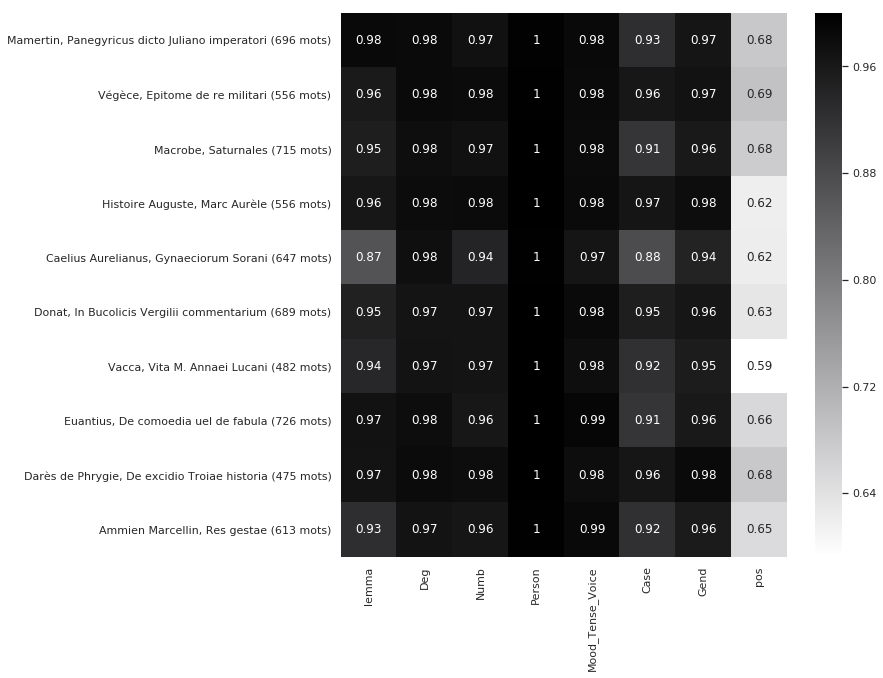

In [14]:


sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})

DF_Tardif = DataFrame(SPLITS_TASK, index=[
    "{} ({} mots)".format(TextsTitles[tid], length) for (tid, *_), length in zip(MilestonesSentences, SIZES)
])

plt.figure(figsize=(10,10))
cmap = sns.cubehelix_palette(250, hue=0.05, rot=0, light=1, dark=0, as_cmap=True)
ax = sns.heatmap(DF_Tardif, annot=True, cmap=cmap)


## Visualisation sur le corpus par POS GOLD

### Recompilation PLATINUM avec NOMpro / NOMcom

In [15]:
PLATINUM_NOMpro = convert_raw(GOLD, task_list=TASKS, lemma_fn=vjui, form_fn=vjui, pos_fn=lambda x: x,
                             clitics_are_duplicate=False, clitics_starts_with_accollade=True)

100%|██████████| 270/270 [00:00<00:00, 13881.61it/s]


In [16]:
from collections import defaultdict

# Dict[Text_id, Dict[POS, [0, 1]]] where 0 = false, 1 = true
Stats_Per_Pos = defaultdict(lambda :defaultdict(list))
_, Scores_Nom_Pro, *_, Score_Knowns = compile_scores(OUTPUT, PLATINUM_NOMpro, 
                                                     task_list=TASKS, known_tokens=KNOWN_TOKENS, 
                                                    known_lemmas=KNOWN_LEMMAS)


start = 0
for text_id, end in enumerate(MILESTONES):
    for (lemma_pred, lemma_truth,  pos_truth) in zip(
        Scores_Nom_Pro["lemma"][0][start:end],
        Scores_Nom_Pro["lemma"][1][start:end],
        Scores_Nom_Pro["pos"][1][start:end]
    ):
        Stats_Per_Pos[text_id][pos_truth].append(int(lemma_pred == lemma_truth))
    start = end

## Now we compute the accuracy and the weight of each POS (in %)

/home/thibault/dev/these/these_env/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


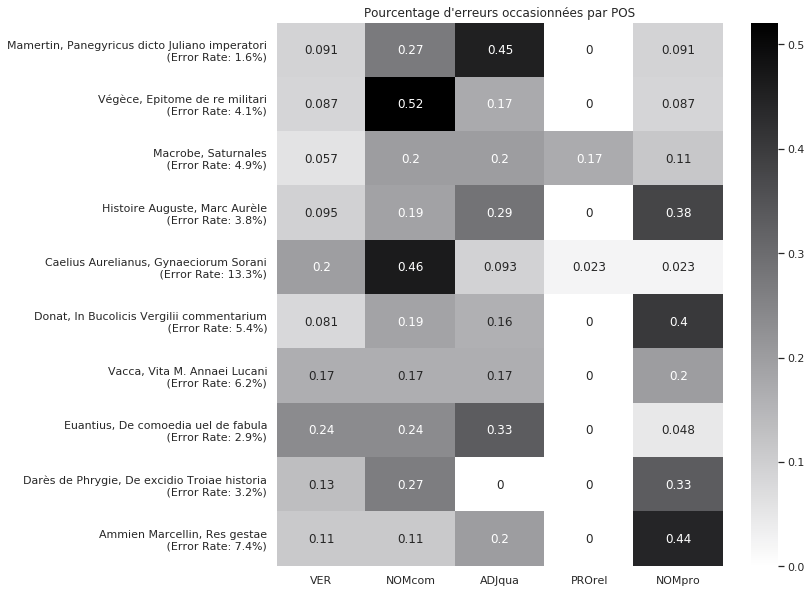

In [17]:
from collections import namedtuple
TextInformation = namedtuple("TextInformation", ["title", "size", "error_rate"])
TextTitleSize = [
    TextInformation(TextsTitles[tid], length, 1-accuracy) 
    for (tid, *_), length, accuracy in zip(
        MilestonesSentences, SIZES, SPLITS_TASK["lemma"]
    )
]

LIMIT_TO_POS = {"VER", "NOMcom", "NOMpro", "PROrel", "ADJqua"}


def compute_accuracy(trues, corpus_size, corpus_accuracy) -> int:
    return ((len(trues) - sum(trues)) / corpus_size) / corpus_accuracy

Impact_Acc_Per_Pos = DataFrame({
    f"{TextTitleSize[text_id].title}\n (Error Rate: {TextTitleSize[text_id].error_rate*100:.1f}%)": {
        pos: compute_accuracy(equals, TextTitleSize[text_id].size, TextTitleSize[text_id].error_rate)
        for pos, equals in texts_values.items()
        if pos in LIMIT_TO_POS
    }
    for text_id, texts_values in Stats_Per_Pos.items()
}).transpose()


# Impact_Acc_Per_Pos[f"Total {len(LIMIT_TO_POS)} POS"] = Impact_Acc_Per_Pos[f"Total {len(LIMIT_TO_POS)} POS"].sum()

sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
fig = plt.figure(figsize=(10,10))
cmap = sns.cubehelix_palette(250, hue=0.05, rot=0, light=1, dark=0, as_cmap=True)
ax = sns.heatmap(Impact_Acc_Per_Pos, annot=True, cmap=cmap)
ax.set_title("Pourcentage d'erreurs occasionnées par POS")
fig.show()

### Impact on Accuracy vs. Size in Corpus

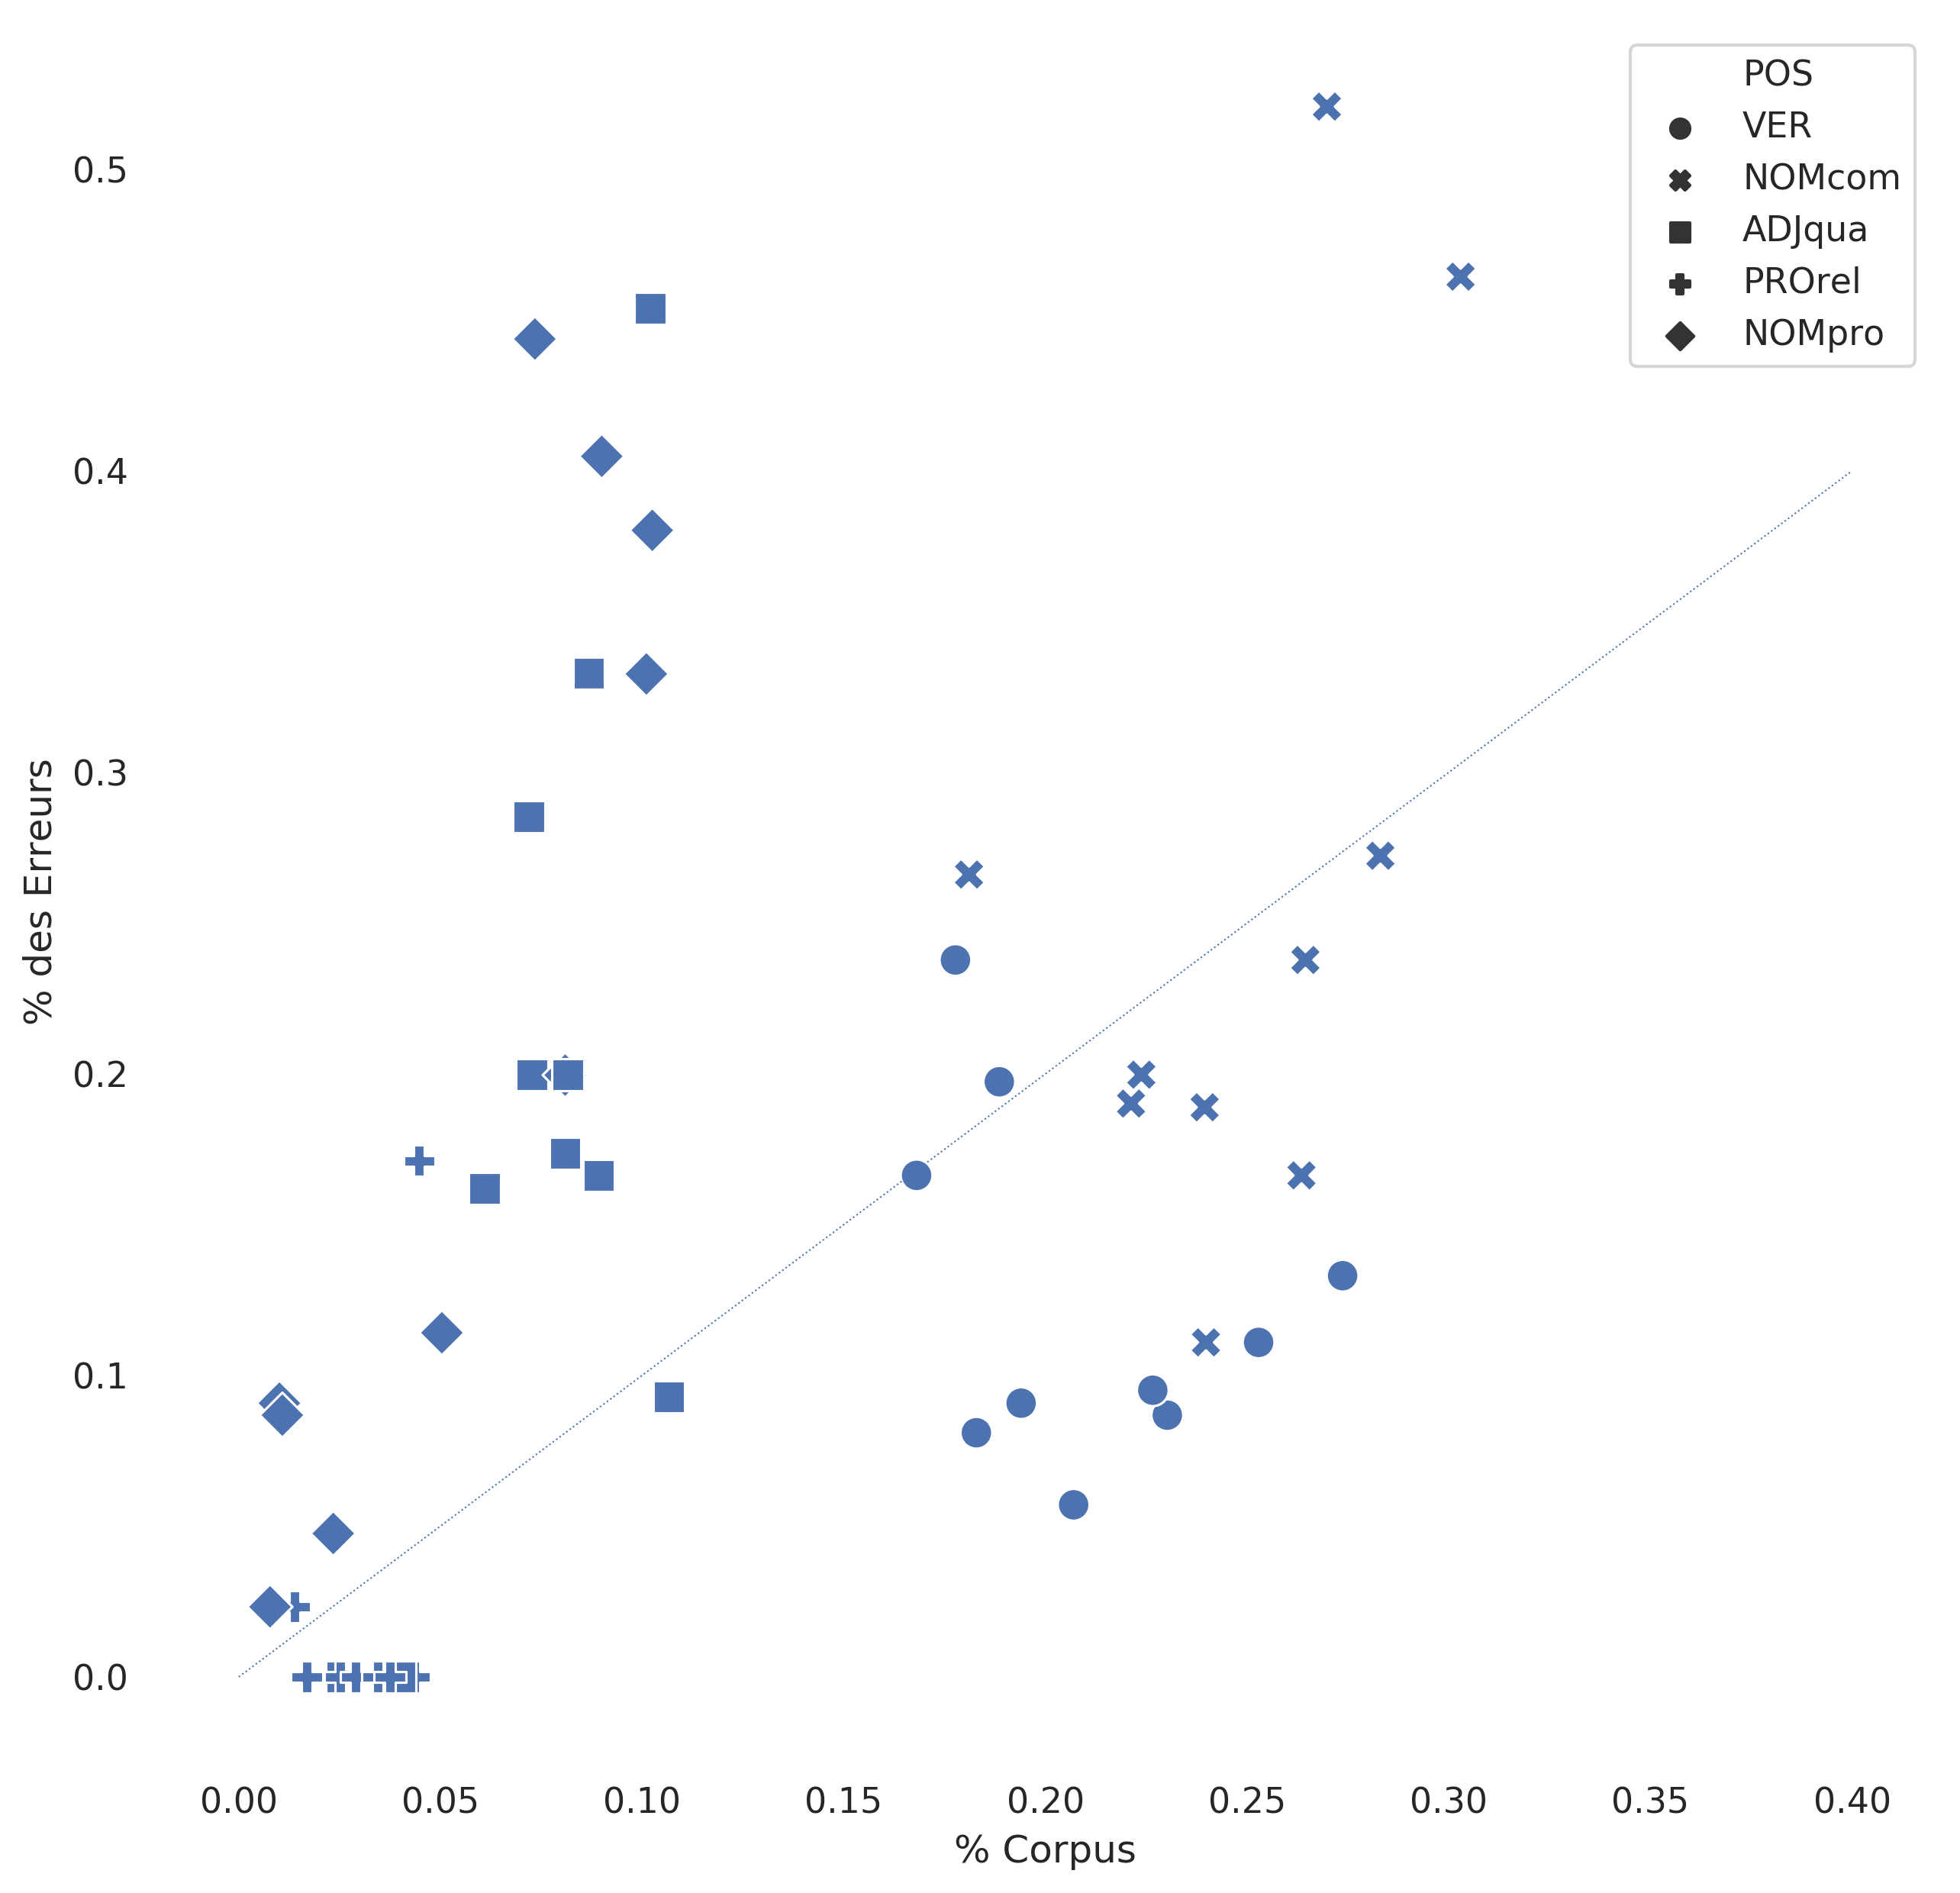

In [18]:
ScatterPos = DataFrame([
    {
        "POS": pos,
        "% Corpus": len(equals)/TextTitleSize[text_id].size, 
        "% des Erreurs": compute_accuracy(
            equals,
            TextTitleSize[text_id].size,
            TextTitleSize[text_id].error_rate
        )
    }
    for text_id, texts_values in Stats_Per_Pos.items()
        for pos, equals in texts_values.items()
        if pos in LIMIT_TO_POS
])
fig, ax = plt.subplots(figsize=(10,10), dpi=300)
ax = sns.scatterplot(
    x="% Corpus", y="% des Erreurs", style="POS", s=100,
    data=ScatterPos, 
    cmap=sns.husl_palette(len(LIMIT_TO_POS)),
    ax=ax
)
# Plot distribution normale
import numpy as np
x = np.linspace(0, 0.4)
plt.plot(x, x, linestyle=':', linewidth=0.5)

ax.plot()
fig.show()

#### As boxplot

3.5004699248120357
0.8957787698412696
0.8957787698412696
            % Corpus  % des Erreurs    Impact
POS                                          
ADJadv.mul  0.001399       0.000000       NaN
ADJadv.ord  0.002874       0.000000  2.407356
ADJcar      0.004310       0.000000  1.461656
ADJdis      0.001546       0.000000  1.469767
ADJmul      0.001377       0.000000       NaN
ADJord      0.006500       0.005805  0.000000
ADJqua      0.081251       0.186637  1.930435
ADV         0.069166       0.050755  0.438710
ADVint      0.003576       0.000000  0.859466
ADVneg      0.007220       0.000000  0.899058
ADVrel      0.006203       0.000000  2.448000
CONcoo      0.067937       0.000000  6.015313
CONsub      0.035399       0.005805  0.669463
INJ         0.004196       0.057063       NaN
NOMcom      0.251645       0.218744  0.000000
NOMpro      0.061880       0.156855  0.000000
PRE         0.070695       0.000000  0.532269
PROdem      0.044519       0.000000  1.354698
PROind      0.017593   

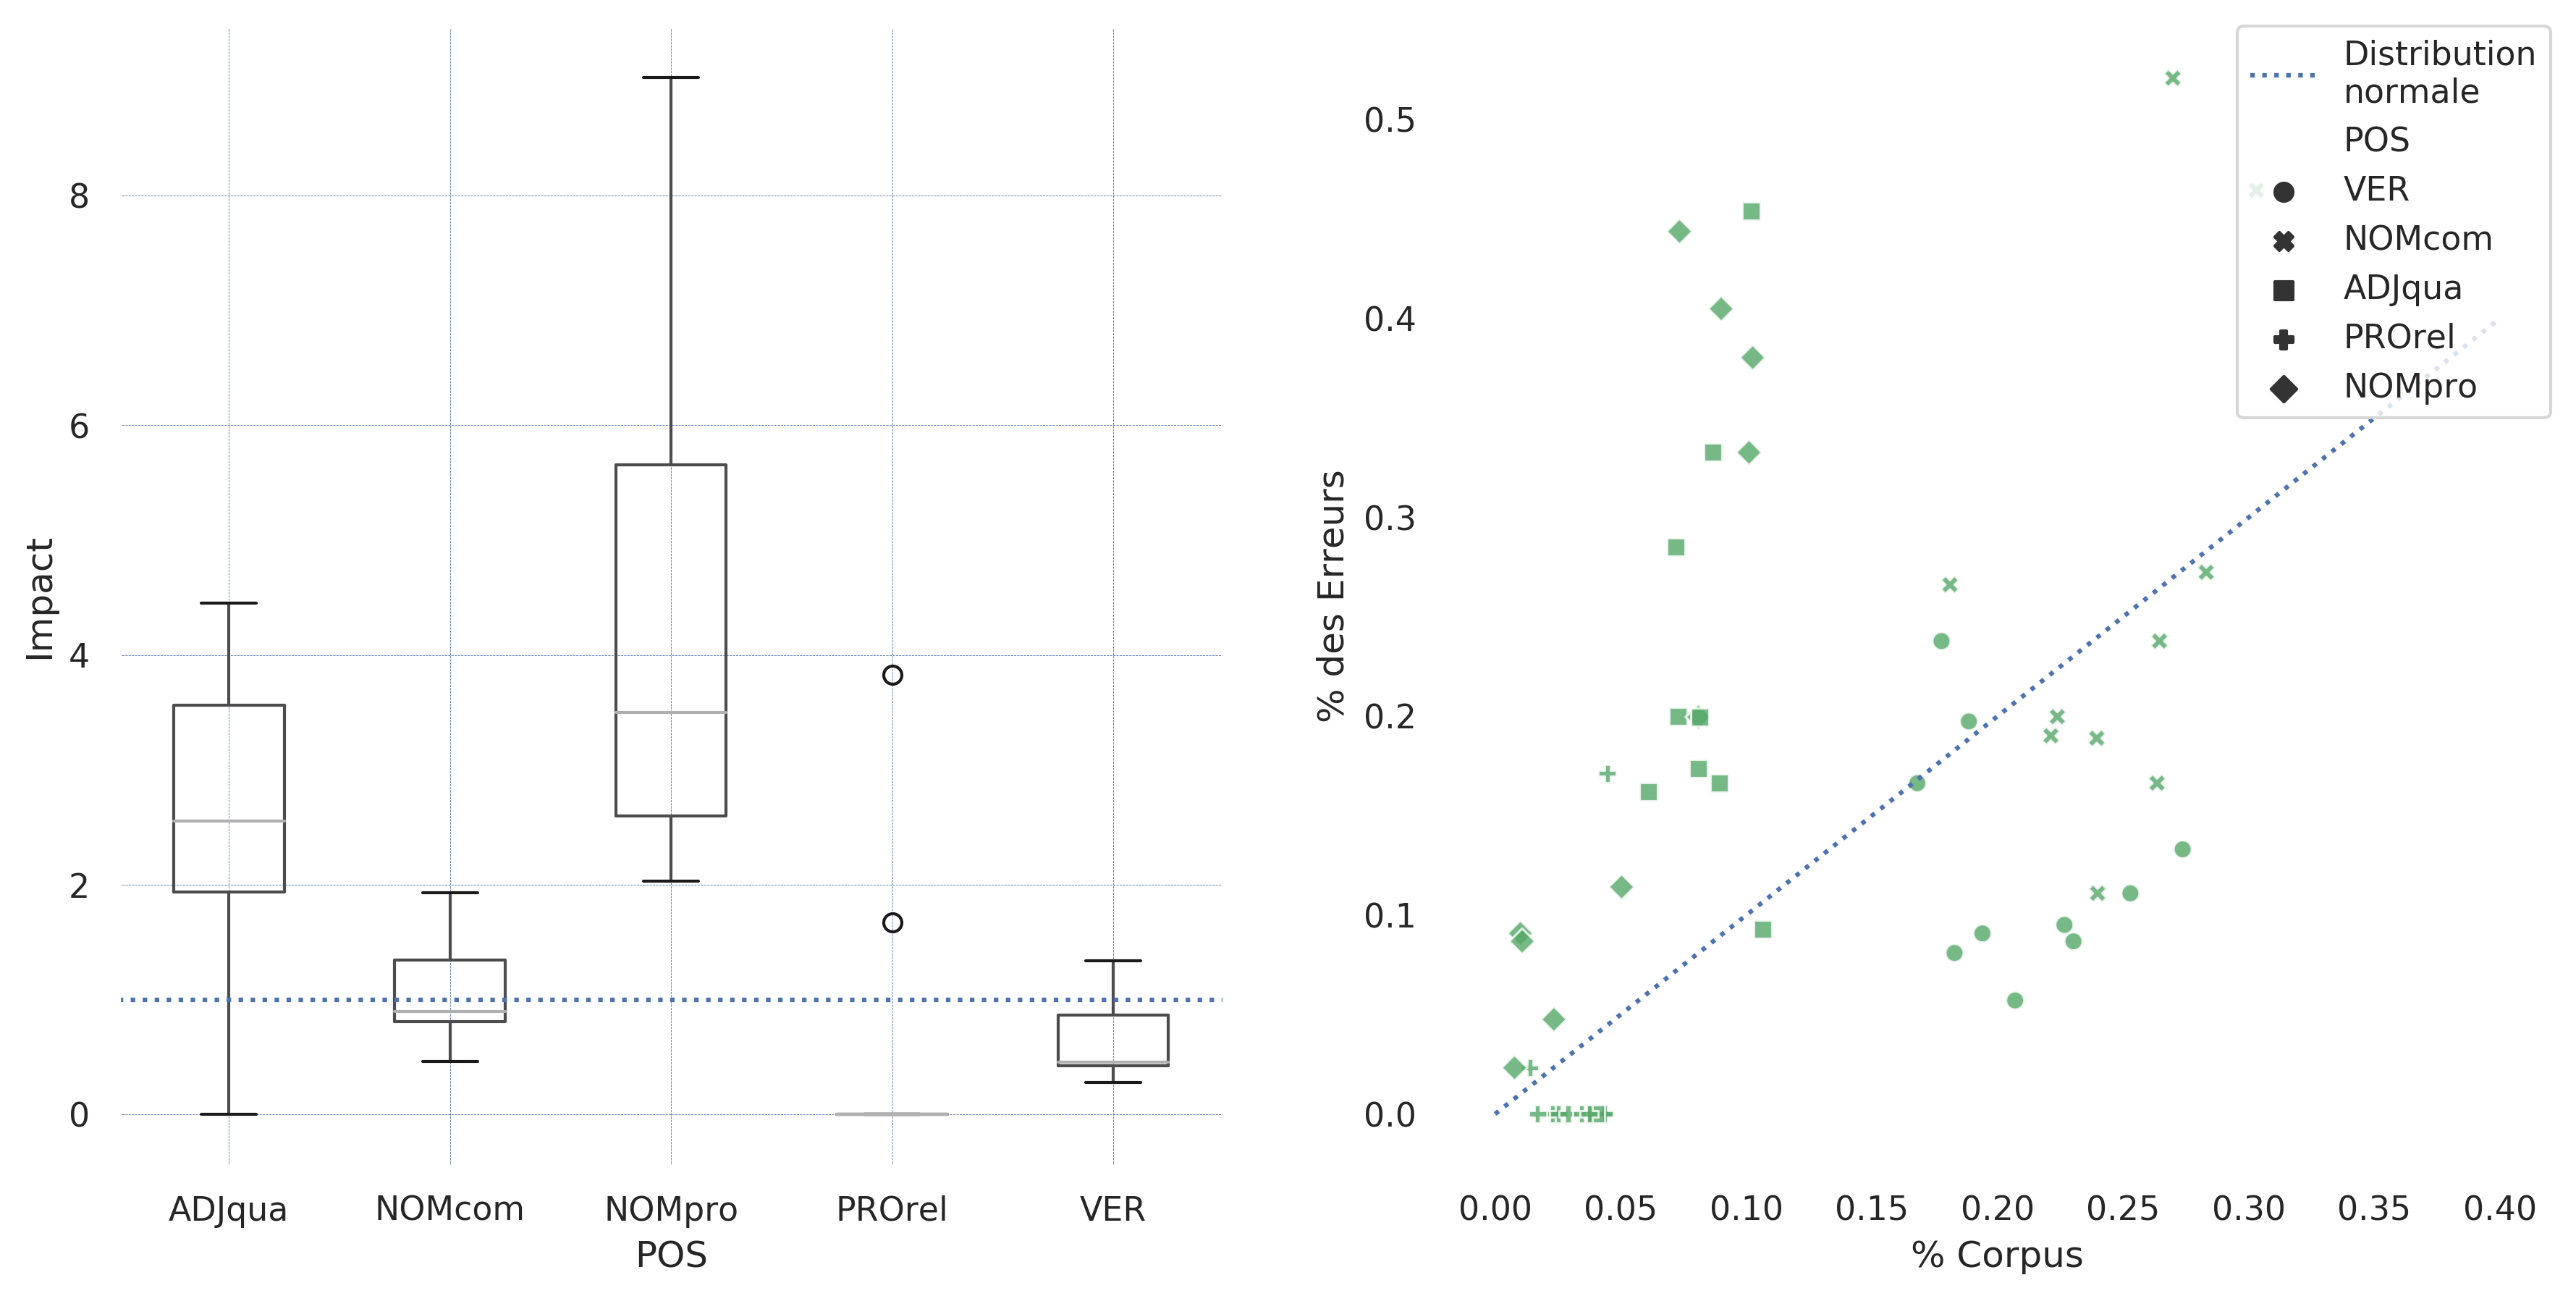

In [19]:
ScatterPos = DataFrame([
    {
        "POS": pos,
        "% Corpus": len(equals)/TextTitleSize[text_id].size, 
        "% des Erreurs": compute_accuracy(
            equals,
            TextTitleSize[text_id].size,
            TextTitleSize[text_id].error_rate
        )
    }
    for text_id, texts_values in Stats_Per_Pos.items()
        for pos, equals in texts_values.items()
        if pos in LIMIT_TO_POS
])
ScatterPos["Impact"] = ScatterPos["% des Erreurs"] / ScatterPos["% Corpus"] 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,7), dpi=300)
# Draw plotbot
ScatterPos.boxplot(ax=ax1, column="Impact", by="POS")
ax1.set_title(label="")
ax1.axhline(y=1, label="Distribution normale", linestyle=":")
ax1.set_ylabel("Impact")
# ax1.text(y=0.8, x=5.6, s="Distribution\nnormale")
ax1.grid(True, color='b', linestyle='--', linewidth=0.2)

# Draw scatter
ax2 = sns.scatterplot(
    x="% Corpus", y="% des Erreurs", style="POS", 
    data=ScatterPos, alpha=0.8,
    color="g",
    ax=ax2
)
x = np.linspace(0, 0.4)
line = ax2.plot(x, x, linestyle=':', color="b", label="Distribution\nnormale")
# line_patch = mpatches.Patch(color='blue', linestyle="--", label="Distribution\nnormale")

handles, labels = ax2.get_legend_handles_labels()
ax2.legend(bbox_to_anchor=(1, 1), loc=1, borderaxespad=0, handles=handles)

fig.suptitle("")
fig.show()

nompro =  ScatterPos.loc[ScatterPos["POS"]=="NOMpro"]["Impact"]
print(nompro.median())#, nompro)
nomcom =  ScatterPos.loc[ScatterPos["POS"]=="NOMcom"]["Impact"]
print(nomcom.median())#, nomcom)
ver =  ScatterPos.loc[ScatterPos["POS"]=="VER"]["Impact"]
print(nomcom.median())#, nomcom)

FullDistrib = DataFrame([
    {
        "POS": pos,
        "% Corpus": len(equals)/TextTitleSize[text_id].size, 
        "% des Erreurs": compute_accuracy(
            equals,
            TextTitleSize[text_id].size,
            TextTitleSize[text_id].error_rate
        )
    }
    for text_id, texts_values in Stats_Per_Pos.items()
        for pos, equals in texts_values.items()
])
FullDistrib["Impact"] = ScatterPos["% des Erreurs"] / ScatterPos["% Corpus"]
FDGB = FullDistrib.groupby("POS").median()
print(FDGB)

### Impact on Accuracy vs. Size in Corpus

We remove PROrel because they are all known

/home/thibault/dev/these/these_env/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


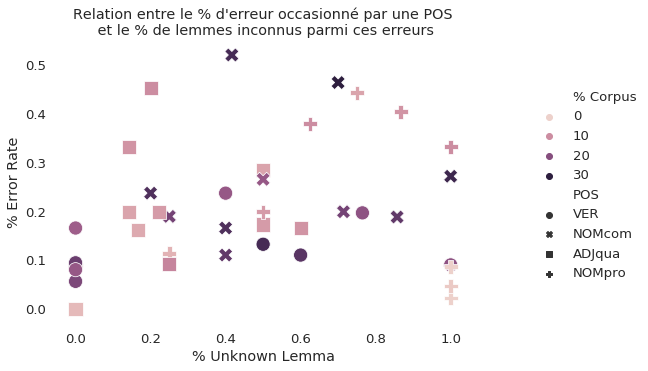

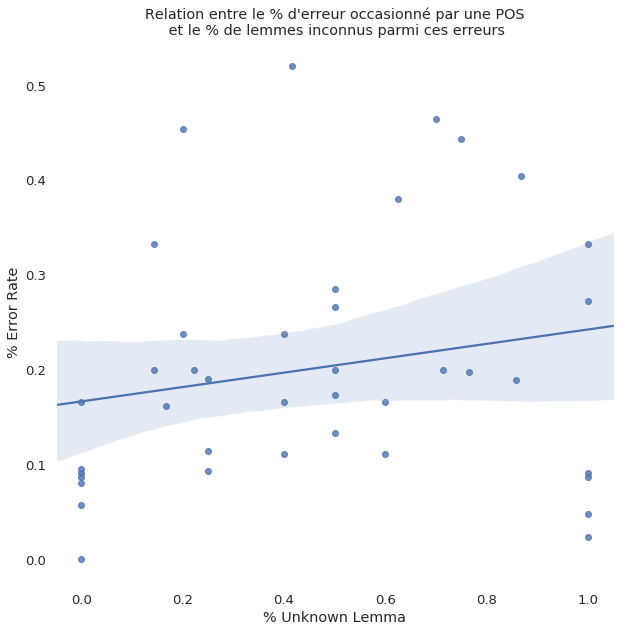

In [20]:
# Compile data to take into account LEMMA and POS
LIMIT_TO_POS_UNKNOWN = {"VER", "NOMcom", "NOMpro", "ADJqua"}
LemmaPosUnknown = defaultdict(lambda :defaultdict(lambda: defaultdict(list)))
start = 0


for text_id, end in enumerate(MILESTONES):
    for token in Score_Knowns[start:end]:
        LemmaPosUnknown[text_id][token["GOLD"]["pos"]]["Accuracy"].append(int(token["lemma"]))
        
        if not token["lemma"]:  # If lemmatization is wrong
            LemmaPosUnknown[text_id][token["GOLD"]["pos"]]["KnownTokens"].append(
                int(token["known_token"])
            )
            LemmaPosUnknown[text_id][token["GOLD"]["pos"]]["KnownLemmas"].append(
                int(token["known_lemma"])
            )
    start = end
    
def compute_rate_unknown(score, key):
    if score[key]:
        return 1 - sum(score[key]) / len(score[key])
    return 0

LemmaPosUnknownDataFrame = DataFrame([
    {
        "POS": pos,
        "% Error Rate": compute_accuracy(
            score["Accuracy"],
            TextTitleSize[text_id].size,
            TextTitleSize[text_id].error_rate
        ),
        "% Unknown Tokens": compute_rate_unknown(score, "KnownTokens"),
        "% Unknown Lemma": compute_rate_unknown(score, "KnownLemmas"),
        "% Corpus": round(100*len(score["Accuracy"])/TextTitleSize[text_id].size)
    }
    for text_id, text_values in LemmaPosUnknown.items()
    for pos, score in text_values.items()
    if pos in LIMIT_TO_POS_UNKNOWN
])

with sns.plotting_context("notebook", font_scale=1.2):
    g = sns.relplot(
        x="% Unknown Lemma", y="% Error Rate", style="POS", 
        hue="% Corpus", s=200,
        data=LemmaPosUnknownDataFrame, 
        cmap=sns.husl_palette(len(LIMIT_TO_POS))
    )
    g.fig.set_size_inches(10,5)
    g.fig.axes[0].set_title("Relation entre le % d'erreur occasionné par une POS"
                            "\n et le % de lemmes inconnus parmi ces erreurs")
    g.fig.show()
    
with sns.plotting_context("notebook", font_scale=1.2):
    
    fig, ax = plt.subplots(figsize=(10,10))
    ax = sns.regplot(
        x="% Unknown Lemma", y="% Error Rate",
        data=LemmaPosUnknownDataFrame,
        ax=ax
    )
    ax.set_title("Relation entre le % d'erreur occasionné par une POS"
                            "\n et le % de lemmes inconnus parmi ces erreurs")
    fig.show()

## Visualisation du texte et des erreurs

In [21]:
from IPython.core.display import display, HTML

THRESHOLD = 0.97

pred, truth = RAW_SCORES["lemma"]
pos_pred, pos_truth = RAW_SCORES["pos"]
flatten_tokens = [tok for sent in TOKENS for tok in sent]
ms_start = 0

annotate_pos = False

full = ""
for nice_title, ms_start, ms_end in zip(TextTitleSize, [0] + MILESTONES, MILESTONES):
    text = []
    nb_tokens = ms_end - ms_start
    size = 1 / nice_title.size
    nb_errors_lemma = 0
    nb_errors_pos = 0
    annotate = "lemma"
    for tok, l_t, l_p, p_t, p_p in zip(
        flatten_tokens[ms_start:ms_end], 
        truth[ms_start:ms_end], pred[ms_start:ms_end],
        pos_truth[ms_start:ms_end], pos_pred[ms_start:ms_end]
    ):
        if l_t == l_p and p_t == p_p:
            text.append(tok)
            continue
            
        annotation = f""
        if l_t != l_p:
            if annotate == "lemma":
                annotation += f"<span class='annotation'><span style='font-style:italic;'>{tok}</span>" +\
                f"[<span style='color:green;'>{l_t}</span>,<span style='color:red;'>{l_p}</span>]</span>"
            nb_errors_lemma += 1
        if p_t != p_p:
            if annotate == "pos":
                annotation += f"<span class='annotation'><span style='font-style:italic;'>{tok}</span>" +\
                f"[<span style='color:green;'>{p_t}</span>,<span style='color:red;'>{p_p}</span>]</span>"
            nb_errors_pos += 1
        text.append(annotation)
            
    text = "<p>"+" ".join(text).replace(" -", "-") + "</p>"
    text = f"""<h2>{nice_title.title}</h2>
    <p>
        <small>
        <b>Accuracy:</b> {accuracy_score(truth[ms_start:ms_end], pred[ms_start:ms_end]):.3f} <br />
        <b>Tokens:</b> {ms_end - ms_start}<br />
        <b>Errors Lemma: </b> {nb_errors_lemma}<br />
        <b>Errors POS: </b> {nb_errors_pos}<br />
        <b>1 error =</b> -{size*100:.1f} % drop in accuracy <br />
        <span style='color:green;'>Ground Truth</span> - <span style='color:red;'>Prediction</span>
        </small>
    </p>
    <p>{text}</p>
    """
    full += text
    display(HTML(text))
    
with open("latintardif2.html", "w") as f:
    f.write(f"""<html>
    <head>
        <title>Export analyse</title>
        <meta charset="utf-8">
    </head>
    <body>
        {full}
    </body>
</html>""")


## Étude de ZIPF

Mots dans le quantile 99      21
Quantité de forme dans le Q99 1472
Quantité de mots              6145

      form     pos  count
4       et  CONcoo    201
6      qui  PROrel    190
21      in     PRE    146
62     sum     VER    114
54      is  PROdem     84
18     sum  VERaux     82
36     hic  PROdem     71
58      ut  CONsub     66
106    non  ADVneg     53
80      ad     PRE     50
24      ab     PRE     49
260   dico     VER     47
444    sui  PROref     46
83     cum  CONsub     45
44     sed  CONcoo     40
130     de     PRE     35
236  omnis  PROind     32
31   etiam     ADV     31
158   ille  PROdem     31
12    quod  CONsub     30
197  alius  PROind     29
pos
PRE       4
PROdem    3
CONsub    3
VER       2
PROind    2
CONcoo    2
VERaux    1
PROrel    1
PROref    1
ADVneg    1
ADV       1
dtype: int64


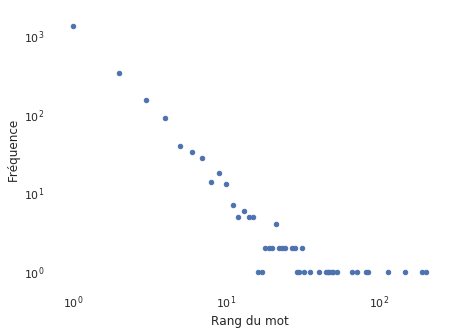

In [22]:
from collections import Counter
from pandas import Series, DataFrame

data = Counter([
    (annot["lemma"].lower(), annot["pos"])
    for sent in PLATINUM_NOMpro
    for annot in sent
])
counter_df = DataFrame([
    dict(zip(("form", "pos", "count"), (lem, pos, cnt))) 
    for (lem, pos), cnt in data.items()
])

reduced = counter_df[
    counter_df["count"] > counter_df["count"].quantile(0.99)
]
print(f'Mots dans le quantile 99      {reduced["count"].count()}')
print(f'Quantité de forme dans le Q99 {reduced["count"].sum()}')
print(f'Quantité de mots              {counter_df["count"].sum()}\n')
print(reduced.sort_values("count", ascending=False))
print(reduced.groupby(['pos']).size().sort_values(ascending=False))

## Drawing ZIPF plot

frequencies = DataFrame(
    [
        dict(zip(("Rang du mot", "Fréquence"), item))
        for item in Counter(
            sorted(list(data.values()))
        ).items()
    ]
)
fig, ax = plt.subplots(figsize=(7,5))
frequencies.plot.scatter(x="Rang du mot", y="Fréquence", logx=True, logy=True, ax=ax)